# Blent : E-commerce purchase prediction

Explication

## Data Analysis

In this first part, we will deep dive in the sample dataset.

In [2]:
# Folder creation with bash command

#%%bash
#mkdir data  

In [3]:
# Extract sample via API

#%%capture
#%%bash
#wget https://blent-learning-user-ressources.s3.eu-west-3.amazonaws.com/training/ml_engineer_facebook/data/sample.csv

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
d = os.getcwd()
df = pd.read_csv(d+"\\data\\sample.csv")

In [5]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [6]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

In [7]:
#Convert event_time to datetime type and extract day, hour and minute

df["event_time"] = pd.to_datetime(df["event_time"])

df["event_day"] = df["event_time"].dt.day
df["event_hour"] = df["event_time"].dt.hour
df["event_minute"] = df["event_time"].dt.minute

In [7]:
print("Samples starts on {} and finishes on {}".format(df["event_time"].min(), df["event_time"].max()))

Samples starts on 2019-10-01 00:00:00 and finishes on 2019-10-01 23:59:59


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply seaborn style on matplotlib
sns.set()

### Time evolution analysis

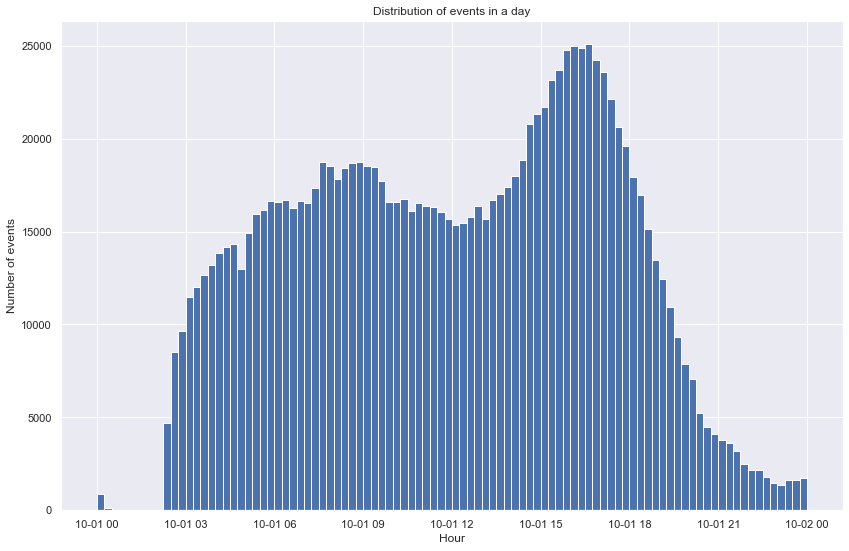

In [9]:
#Plot distribution of events on Oct 1st, 2019

plt.figure(figsize=(14, 9))
plt.hist(df["event_time"], bins=96)
plt.xlabel("Hour")
plt.ylabel("Number of events")
plt.title("Distribution of events in a day")
plt.show()

The histogram above shows that there is a peak of activity between 3pm and 6pm then a big drop until midnight

### Events analysis

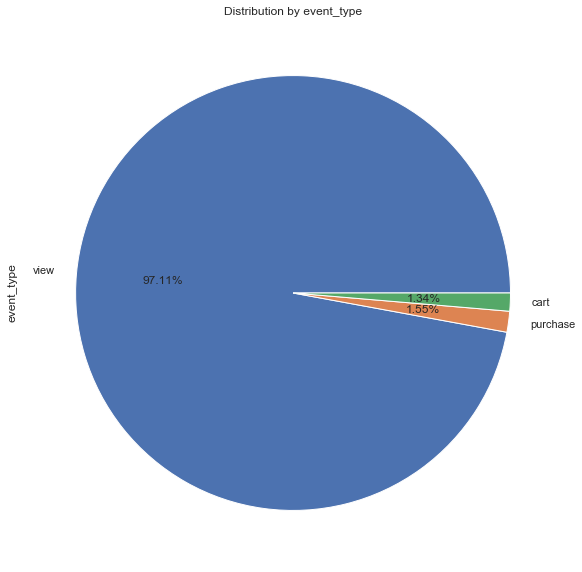

In [10]:
plt.figure(figsize=(10, 10))
df["event_type"].value_counts().plot(kind="pie", autopct='%1.2f%%')
plt.title("Distribution by event_type")
plt.show()

The pie chart above show that a huge proportion of events are only views. Moreover there are as mush carts as purchases

### User analysis

In [11]:
#df_user = df[["user_id", "user_session"]].groupby(["user_id"]).count()["user_session"].value_counts()
#df_user /= df_user.sum()

In [12]:
#df[["user_id", "user_session"]].groupby(["user_id"]).count()["user_session"]

In [13]:
df_user = df[["user_id", "user_session"]].drop_duplicates() \
    .groupby(["user_id"]) \
    .count()["user_session"] \
    .value_counts()
df_user /= df_user.sum()

In [14]:
#print(df_user.head(30))

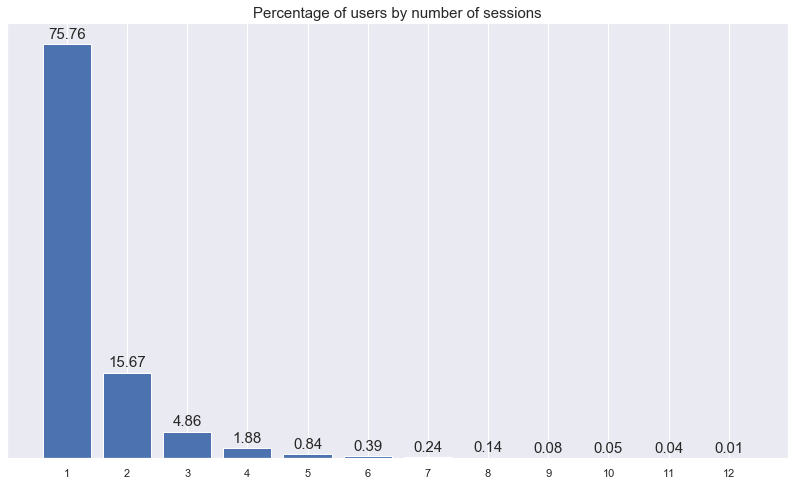

In [15]:
n_bar=12
plt.figure(figsize=(14,8))
ax = plt.gca()
plot = plt.bar(df_user.index[:n_bar], df_user[:n_bar])


for item in plot:
    height = item.get_height()
    ax.annotate(
        '{:2.2f}'.format(height * 100),
        xy=(item.get_x() + item.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        fontsize=15,
        ha='center', va='bottom'
    )
plt.title("Percentage of users by number of sessions", fontsize = 15)
plt.xticks(range(1, n_bar+1))
plt.yticks(None)
ax.axes.yaxis.set_visible(False)
plt.show()

In [16]:
data_purchase = df.copy()
data_purchase['purchased'] = np.where(data_purchase['event_type'] == "purchase", 1, 0)
#data_purchase['purchased'] = data_purchase \
#    .groupby(["user_session"])['purchased'] \
#    .transform("max")

#data_purchase["purchased"].value_counts() / data_purchase["purchased"].shape[0]

data_purchase = data_purchase.groupby(["user_session"])["purchased"].max()
data_purchase = data_purchase.value_counts()
data_purchase/=data_purchase.sum()
data_purchase

0    0.939536
1    0.060464
Name: purchased, dtype: float64

6% of sessions ends up with a purchase

### Product analysis

In [17]:
df_category = df.copy()
df_category = df_category.dropna(subset=["category_code"],axis=0)
df_category["category"] = df_category["category_code"].apply(lambda x : x.split(".")[0])
df_category = pd.concat([df_category, pd.get_dummies(df_category["event_type"])], axis=1)

In [18]:
df_category = df_category.groupby("category")["cart", "purchase", "view"].sum()
df_category

C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,cart,purchase,view
category,,,
accessories,8.0,45.0,7363.0
apparel,0.0,170.0,38314.0
appliances,556.0,1953.0,136343.0
auto,161.0,226.0,30937.0
computers,157.0,804.0,68970.0
construction,139.0,233.0,23395.0
country_yard,1.0,4.0,654.0
electronics,14034.0,11371.0,452355.0
furniture,19.0,204.0,33020.0


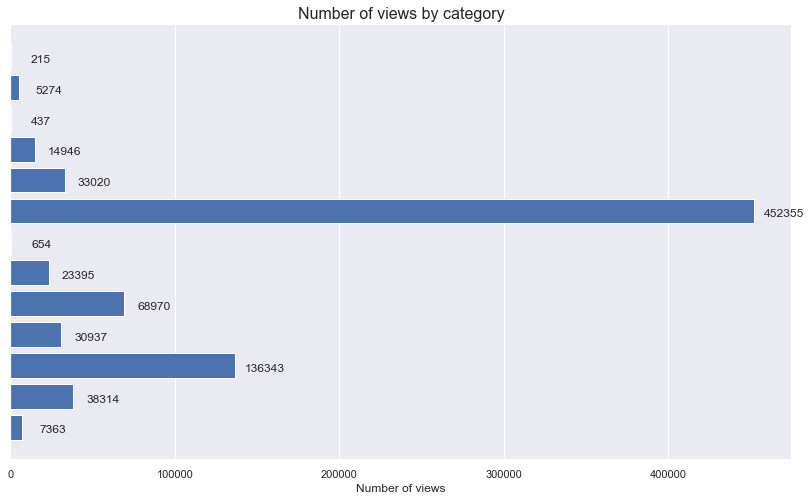

In [19]:
plt.figure(figsize=(14,8))
ax = plt.gca()
plot_2 = plt.barh(df_category.index, df_category["view"])

for item in plot_2:
    width = item.get_width()
    ax.annotate(
    "{}".format(int(width)),
    xy = (width,item.get_y()),
    xytext=(30, 5),
    textcoords="offset points",
    fontsize=12,
    ha='center', va='bottom'
    )

plt.title("Number of views by category", fontsize = 16)
plt.xlabel("Number of views")
plt.ylabel("Category")
ax.axes.yaxis.set_visible(False)

plt.show()

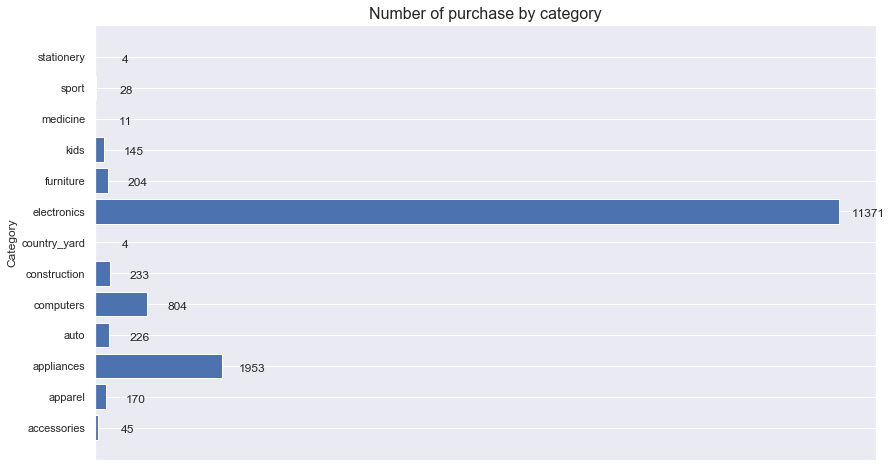

In [20]:
plt.figure(figsize=(14,8))
ax = plt.gca()
plot_2 = plt.barh(df_category.index, df_category["purchase"])

for item in plot_2:
    width = item.get_width()
    ax.annotate(
    "{}".format(int(width)),
    xy = (width,item.get_y()),
    xytext=(30, 5),
    textcoords="offset points",
    fontsize=12,
    ha='center', va='bottom'
    )

plt.title("Number of purchase by category", fontsize = 16)
plt.xlabel("Number of purchase")
plt.ylabel("Category")
ax.axes.xaxis.set_visible(False)

plt.show()

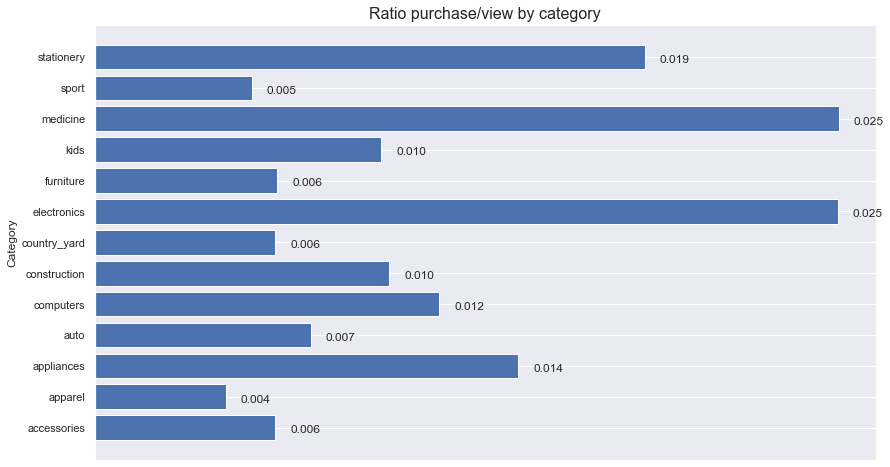

In [21]:
plt.figure(figsize=(14,8))
ax = plt.gca()
plot_2 = plt.barh(df_category.index, df_category["purchase"]/df_category["view"])

for item in plot_2:
    width = item.get_width()
    ax.annotate(
    "{:2.3f}".format(width),
    xy = (width,item.get_y()),
    xytext=(30, 5),
    textcoords="offset points",
    fontsize=12,
    ha='center', va='bottom'
    )

plt.title("Ratio purchase/view by category", fontsize = 16)
plt.xlabel("Ratio purchase/view")
plt.ylabel("Category")
ax.axes.xaxis.set_visible(False)

plt.show()

We see that in absolute value, the categories with highest views have highest purchase action. However, when we look at the purchase/view ratio, we see that categories with low views like medecine have the same ratio than electronics

### User behaviour

First we check if we see a difference of behaviour between views and purchase

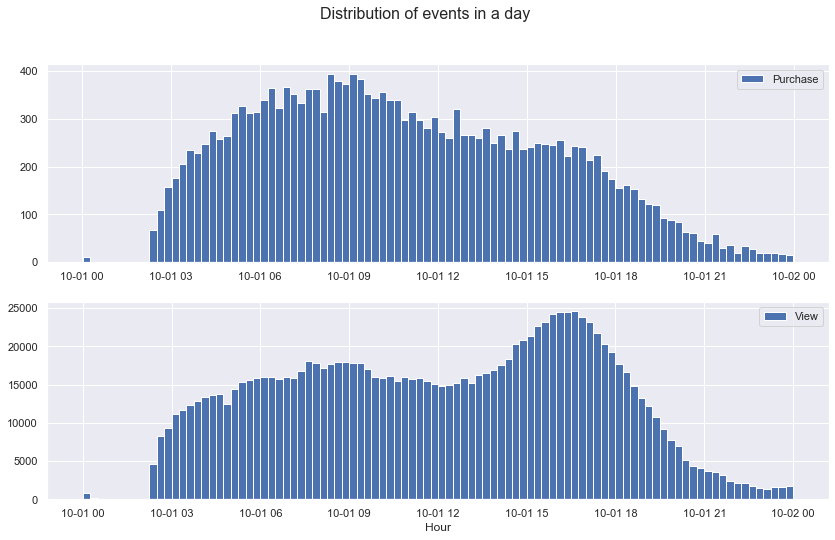

In [22]:
#Plot distribution of events on Oct 1st, 2019
fig, (ax1, ax2) = plt.subplots(2, figsize=(14,8))


ax1.hist(df["event_time"][df["event_type"] == "purchase"], bins=96, label = "Purchase")

ax2.hist(df["event_time"][df["event_type"] == "view"], bins=96, label = "View")

plt.xlabel("Hour")
ax1.legend()
ax2.legend()
plt.suptitle("Distribution of events in a day", fontsize = 16)
plt.show()

We notice that there is a peak of views around 4pm whereas the purchases are more smoothed with highest values between 6am and 9am.

Now let's check the average duration of a session (exluding one-event sessions)

In [23]:

df_duration = df.loc[:,("user_session", "event_time")]

df_duration["time_min"] = df_duration.groupby(["user_session"])["event_time"].transform("min")
df_duration["time_max"] = df_duration.groupby(["user_session"])["event_time"].transform("max")
df_duration["duration"] = (df_duration["time_max"]-df_duration["time_min"]).dt.seconds
df_duration = df_duration[df_duration["duration"]> 0].drop_duplicates(subset="user_session")

moy = df_duration["duration"].mean()

print("The average session duration is {} minutes and {} seconds".format(int(moy // 60), int(moy % 60)))

The average session duration is 8 minutes and 55 seconds


In [23]:
#Solution from Blent

#data=df

#sessions_duration = data \
#    .groupby("user_session").agg(
#        {"event_time": [np.min, np.max]}
#    ) \
#    .reset_index()

#sessions_duration["amax"] = pd.to_datetime(sessions_duration["event_time"]["amax"])
#sessions_duration["amin"] = pd.to_datetime(sessions_duration["event_time"]["amin"])
#sessions_duration.columns = sessions_duration.columns.get_level_values(0)
#sessions_duration["duration"] = (sessions_duration["amax"] - sessions_duration["amin"])
# On retire les sessions de durée nulle (i.e. un seul événement)
#sessions_duration = sessions_duration[sessions_duration["duration"].dt.seconds > 0]
#sessions_duration["duration"].mean()
#sessions_duration

Now let's see the distribution of duration for sessions that last less than 1 hour.

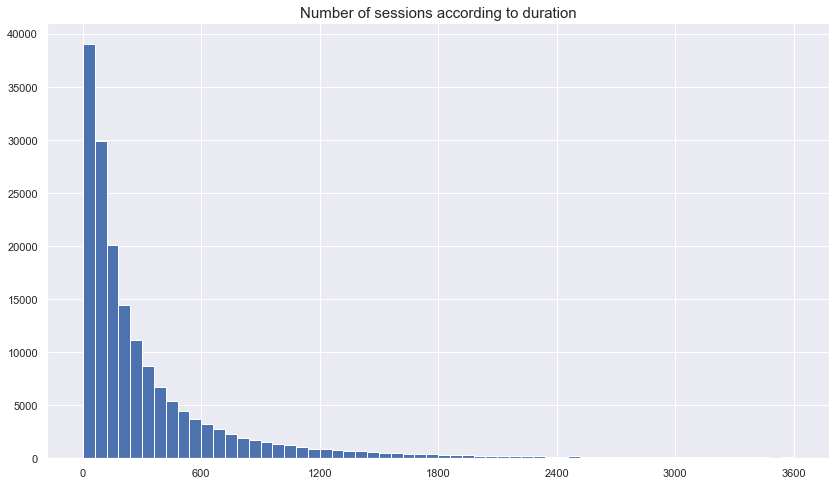

In [24]:
seuil = 3600

plt.figure(figsize=(14,8))
plt.hist(df_duration["duration"][df_duration["duration"]<seuil], bins = int(seuil/60))
plt.xticks([x*600 for x in range(0,int(seuil/600) + 1)])
plt.title("Number of sessions according to duration", fontsize = 15)
plt.show()

We see that most of sessions last less than 5 minutes.

FInally let's check if we have more chance to end up with a purchase when the session lasts more than 1 hour.

In [25]:
df_1hour = pd.concat([df, pd.get_dummies(df["event_type"])], axis=1)

df_1hour = df_1hour \
    .groupby("user_session").agg(
        {"event_time": [np.min, np.max], "purchase" : np.max}
    ) \
    .reset_index()

df_1hour.columns = ["user_session", "start", "end", "purchase"]

df_1hour["duration"] = (df_1hour["end"]-df_1hour["start"]).dt.seconds

df_1hour["more_than_one_hour"] = np.where(df_1hour["duration"] > 3600, 1, 0)

print("{:2.2f}% of sessions that lasted less than 1h ended with a purchase" \
      .format(df_1hour[df_1hour["more_than_one_hour"] == 0]["purchase"].sum()/len(df_1hour[df_1hour["more_than_one_hour"] == 0]))
     )

print("{:2.2f}% of sessions that lasted more than 1h ended with a purchase" \
      .format(df_1hour[df_1hour["more_than_one_hour"] == 1]["purchase"].sum()/len(df_1hour[df_1hour["more_than_one_hour"] == 1]))
     )

0.06% of sessions that lasted less than 1h ended with a purchase
0.08% of sessions that lasted more than 1h ended with a purchase


To sum up there is likely a chance for a session to end with a purchase when it lasts more than one hour than when it lasts less than 1 hour.